
**Hospital Stay Duration Prediction Model**

This module implements a machine learning approach to predict hospital length of stay
using baseline patient characteristics, vital sign statistics, and diagnosis information.
The model avoids complex time-series analysis by using statistical summaries and measurement
patterns to represent patient status.

Features used in the prediction:

Dataset Tables:

1. Vital Signs Dataset (over_20_records.csv):
   - Contains patient measurements during hospitalization
   - Key columns: PatientNum, PatientAgeAtAdmission, TotalHospitalDays, Execution_Date,
     HoursFromAdmission, Parameter_Name, ResultValue, NumericResult, ReadingSequence
   - Each row represents a single measurement for a specific patient and parameter

2. Diagnoses Dataset (patients_diagnoses.csv):
   - Contains patients' diagnostic information using ICD-9/ICD-10 codes
   - Key columns: PatientNum, ICD9
   - Each row represents a single diagnosis for a specific patient

   
1. Baseline Patient Features:
   - Age at admission
   - BMI (body mass index)
   - Weight

2. Vital Sign Statistical Features:
   For each vital sign (heart rate, blood pressure, temperature, etc.):
   - Measurement frequency (count)
   - Statistical summaries (mean, median, std, min, max, range, trend)

3. Diagnosis-Based Features:
   - Total diagnosis count
   - Binary indicators for major disease categories
   - Binary indicators for common specific diagnosis codes

The implementation follows these main steps:
1. Data loading and cleaning
2. Feature extraction and transformation
3. Model training with multiple regression algorithms
4. Performance evaluation and visualization
5. Feature importance analysis




Loading vital signs data from over_20_records.csv...
Converting column PatientNum to numeric
Converting column PatientAgeAtAdmission to numeric
Converting column TotalHospitalDays to numeric
Converting column HoursFromAdmission to numeric
Converting column NumericResult to numeric
Loaded data with 18914 rows and 9 columns
Number of patients: 712
Loading diagnoses data from patients_diagnoses.csv...
Loaded 10054 diagnosis records for 712 patients
Extracted baseline features for 712 patients
Extracted parameter statistics for 712 patients
Parameter feature columns created: 64
Preparing diagnosis features...
Processing 10054 diagnosis records...
Sample diagnoses data:
   PatientNum   ICD9   Description                   Entry_Date
0      640012   8202  אבחנות בקבלה  2020-03-25 17:53:35.9070000
1      640012  Z7935  אבחנות בקבלה  2020-03-30 15:31:16.7270000
2      640012  82020  אבחנות בקבלה  2020-03-30 15:31:16.7270000
3      640012    250    אבחנות רקע  2020-03-30 17:57:19.5570000
4     

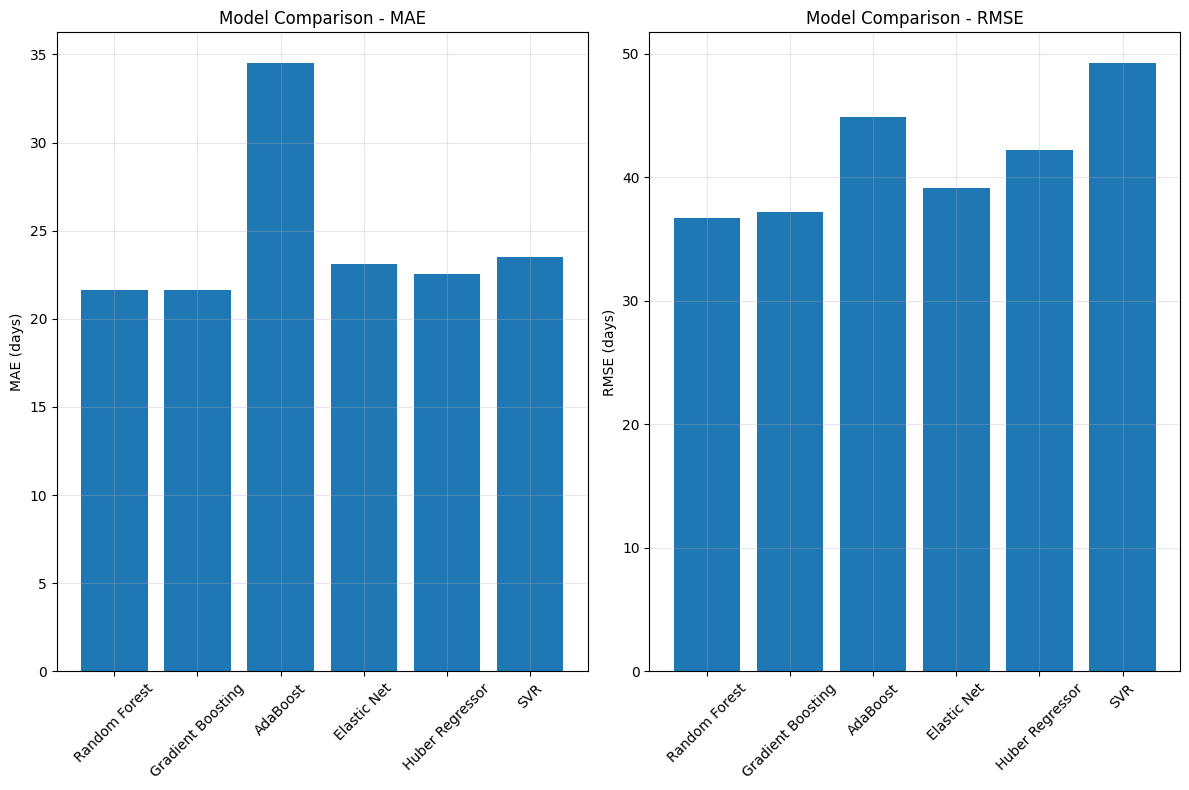

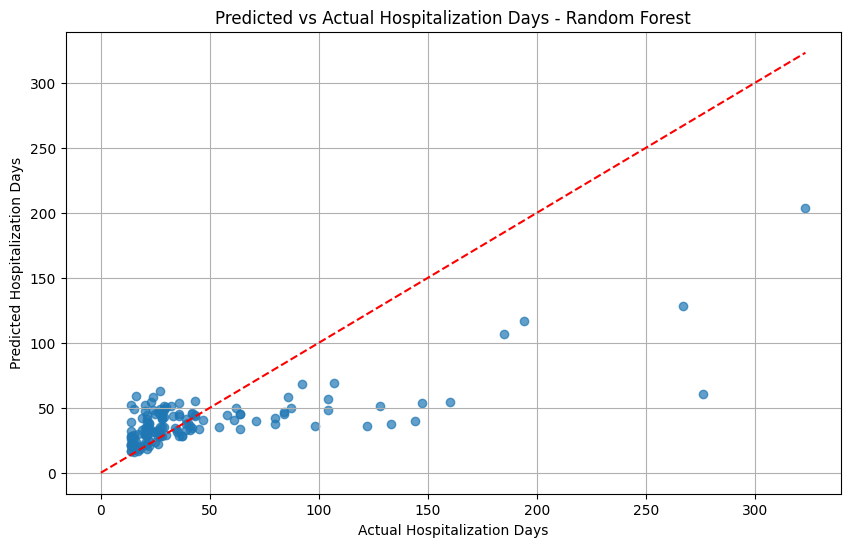

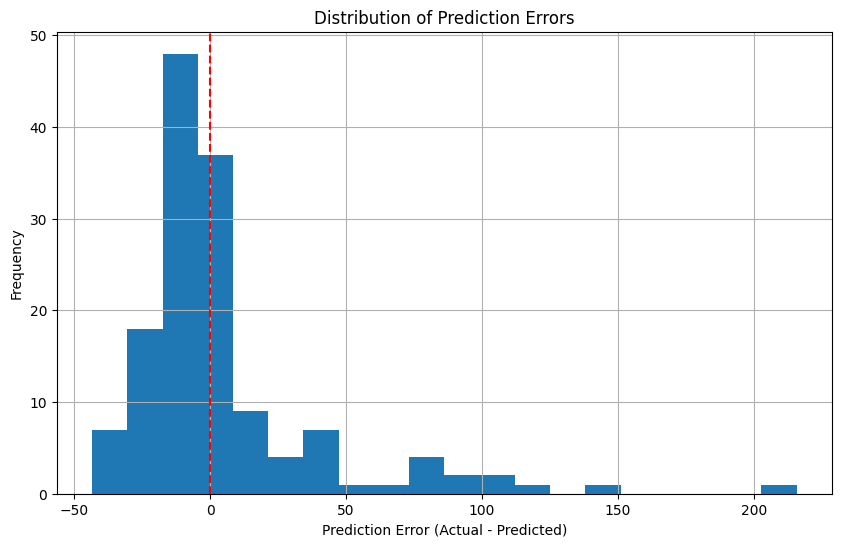


Top 15 Most Important Features:
                  Feature  Importance
67        diagnosis_count    0.311867
0   PatientAgeAtAdmission    0.045542
1                     BMI    0.043926
2                  Weight    0.029164
90           has_icd_Z815    0.021755
66         סוכר בדם_trend    0.020299
18      לחץ סיסטולי_trend    0.019176
52               כאב_mean    0.017904
92            has_icd_715    0.017189
25     לחץ דיאסטולי_range    0.016430
23       לחץ דיאסטולי_min    0.015616
51              כאב_count    0.015083
20      לחץ דיאסטולי_mean    0.014285
15        לחץ סיסטולי_min    0.013513
10             דופק_trend    0.013247


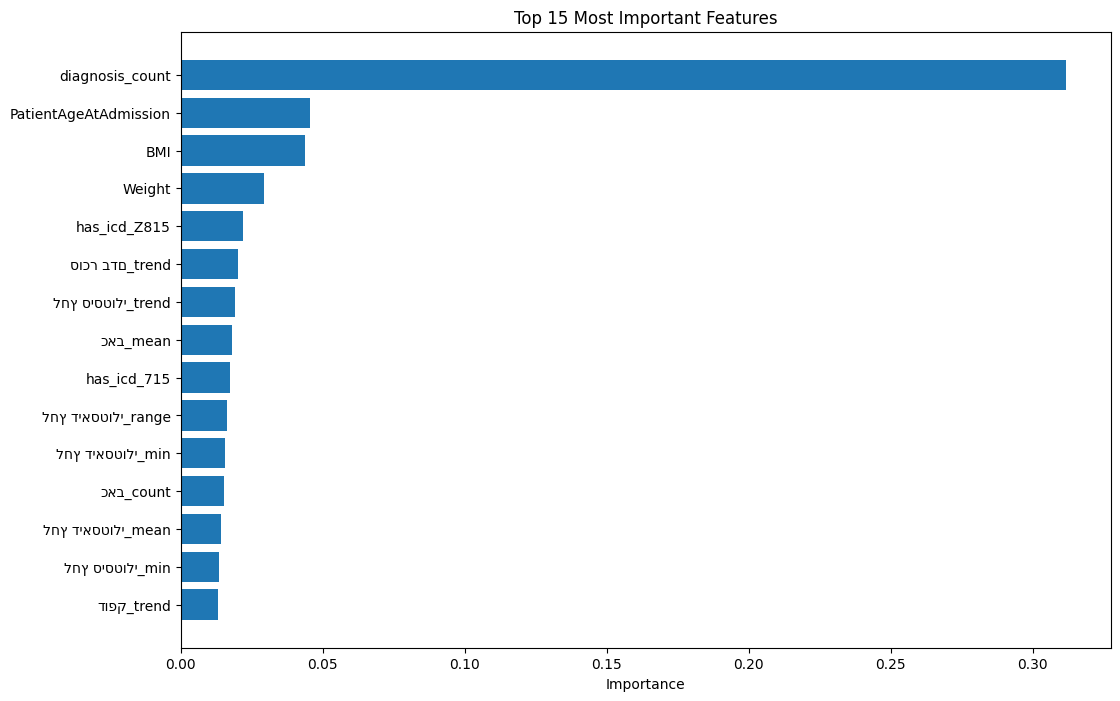


Prediction completed successfully.


In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import ElasticNet, HuberRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Function to extract baseline patient features
def extract_baseline_features(df):
    """Extract baseline features from patient data"""
    # Group by patient to get unique patient records
    patients_df = df.groupby('PatientNum').agg({
        'PatientAgeAtAdmission': 'first',
        'TotalHospitalDays': 'first'
    }).reset_index()

    # Extract BMI and Weight as baseline features (using the latest value)
    bmi_data = df[df['Parameter_Name'] == 'BMI'].sort_values('HoursFromAdmission')
    weight_data = df[df['Parameter_Name'] == 'משקל'].sort_values('HoursFromAdmission')

    # Create DataFrames with just the latest BMI and weight values
    latest_bmi = bmi_data.groupby('PatientNum').last()[['NumericResult']].rename(
        columns={'NumericResult': 'BMI'})
    latest_weight = weight_data.groupby('PatientNum').last()[['NumericResult']].rename(
        columns={'NumericResult': 'Weight'})

    # Merge baseline features
    patients_df = patients_df.merge(latest_bmi, on='PatientNum', how='left')
    patients_df = patients_df.merge(latest_weight, on='PatientNum', how='left')

    print(f"Extracted baseline features for {len(patients_df)} patients")

    return patients_df

# Function to process diagnosis data
def prepare_diagnosis_features(diagnoses_df):
    """Process ICD9/ICD10 diagnoses into features for the model"""
    print(f"Processing {len(diagnoses_df)} diagnosis records...")

    # Debug information
    print("Sample diagnoses data:")
    print(diagnoses_df.head())
    print(f"Data types: {diagnoses_df.dtypes}")

    # Convert patient number to numeric
    if not pd.api.types.is_numeric_dtype(diagnoses_df['PatientNum']):
        diagnoses_df['PatientNum'] = pd.to_numeric(diagnoses_df['PatientNum'], errors='coerce')
    diagnoses_df = diagnoses_df.dropna(subset=['PatientNum'])
    diagnoses_df['PatientNum'] = diagnoses_df['PatientNum'].astype(int)

    # Handle ICD9 codes
    diagnoses_df['ICD9'] = diagnoses_df['ICD9'].astype(str).str.strip()
    diagnoses_df = diagnoses_df[diagnoses_df['ICD9'].str.len() > 0]
    diagnoses_df['ICD9_category'] = diagnoses_df['ICD9'].str.extract(r'([A-Z]?[0-9]{1,3})')[0]

    # Check extracted categories
    print("\nSample ICD9 categories extracted:")
    print(diagnoses_df[['ICD9', 'ICD9_category']].head(10))
    print(f"Number of missing categories: {diagnoses_df['ICD9_category'].isna().sum()}")

    # Convert to string to prevent issues
    diagnoses_df['ICD9_category'] = diagnoses_df['ICD9_category'].fillna('').astype(str)

    # Create unique patient list
    patient_diagnoses = pd.DataFrame(diagnoses_df['PatientNum'].unique(), columns=['PatientNum'])

    # Add total diagnosis count
    diagnosis_counts = diagnoses_df.groupby('PatientNum').size().reset_index(name='diagnosis_count')
    patient_diagnoses = patient_diagnoses.merge(diagnosis_counts, on='PatientNum', how='left')

    # Define disease categories
    disease_categories = {
        'infectious': ['001', '002', '003', '004', '005', '006', '007', '008', '009', '01', '02', '03', '04', '05', '06', '07', '08', '09', 'A', 'B'],
        'neoplasms': ['14', '15', '16', '17', '18', '19', '20', '21', '22', '23', 'C', 'D0', 'D1', 'D2', 'D3', 'D4'],
        'endocrine': ['24', '25', '26', '27', 'E'],
        'blood': ['28', '29', 'D5', 'D6', 'D7', 'D8'],
        'mental': ['29', '30', '31', 'F'],
        'nervous': ['32', '33', '34', '35', '36', '37', 'G'],
        'circulatory': ['39', '40', '41', '42', '43', '44', '45', 'I'],
        'respiratory': ['46', '47', '48', '49', '50', '51', 'J'],
        'digestive': ['52', '53', '54', '55', '56', '57', 'K'],
        'genitourinary': ['58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', 'N'],
        'pregnancy': ['63', '64', '65', '66', '67', 'O'],
        'skin': ['68', '69', '70', '71', 'L'],
        'musculoskeletal': ['71', '72', '73', 'M'],
        'congenital': ['74', '75', 'Q'],
        'perinatal': ['76', '77', 'P'],
        'symptoms': ['78', '79', 'R'],
        'injury': ['80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', 'S', 'T'],
        'external_causes': ['E', 'V', 'W', 'X', 'Y'],
        'factors': ['Z']
    }

    # Create mapping from ICD code to category
    icd_to_category = {}
    for category, codes in disease_categories.items():
        for code in codes:
            icd_to_category[code] = category

    # Map each diagnosis to appropriate category
    def get_prefix(icd_code):
        if not icd_code or pd.isna(icd_code) or icd_code == '':
            return ''
        icd_code = str(icd_code).strip()
        if len(icd_code) == 0:
            return ''
        if icd_code[0].isalpha():
            return icd_code[0]  # First letter for ICD10 codes
        else:
            # Return first digit for ICD9 codes
            return icd_code[:1]

    # Apply safer function
    diagnoses_df['prefix'] = diagnoses_df['ICD9_category'].apply(get_prefix)

    # Map prefix to category
    diagnoses_df['disease_category'] = diagnoses_df['prefix'].map(icd_to_category)
    diagnoses_df['disease_category'] = diagnoses_df['disease_category'].fillna('other')

    # Check created categories
    print("\nSample disease categories:")
    print(diagnoses_df[['ICD9', 'prefix', 'disease_category']].head(10))
    print(f"Category distribution:")
    print(diagnoses_df['disease_category'].value_counts().head(10))

    # Create flags for each disease category
    for category in list(set(disease_categories.keys())) + ['other']:
        category_counts = diagnoses_df[diagnoses_df['disease_category'] == category].groupby('PatientNum').size().reset_index(name=f'has_{category}')
        patient_diagnoses = patient_diagnoses.merge(category_counts, on='PatientNum', how='left')
        patient_diagnoses[f'has_{category}'] = patient_diagnoses[f'has_{category}'].fillna(0)

        # Convert to binary flag
        patient_diagnoses[f'has_{category}'] = (patient_diagnoses[f'has_{category}'] > 0).astype(int)

    # Identify common diagnosis codes and add flags
    valid_codes = diagnoses_df['ICD9_category'].dropna()
    if len(valid_codes) > 0:
        top_codes = valid_codes.value_counts().head(20).index

        for code in top_codes:
            if not pd.isna(code) and str(code).strip() != '':
                code_counts = diagnoses_df[diagnoses_df['ICD9_category'] == code].groupby('PatientNum').size().reset_index(name=f'has_icd_{code}')
                patient_diagnoses = patient_diagnoses.merge(code_counts, on='PatientNum', how='left')
                patient_diagnoses[f'has_icd_{code}'] = patient_diagnoses[f'has_icd_{code}'].fillna(0)

                # Convert to binary flag
                patient_diagnoses[f'has_icd_{code}'] = (patient_diagnoses[f'has_icd_{code}'] > 0).astype(int)

    print(f"Created diagnosis features for {len(patient_diagnoses)} patients")
    print(f"Feature columns created: {len(patient_diagnoses.columns) - 1}")  # -1 for PatientNum column

    return patient_diagnoses

# Function to extract both counts and statistical summaries of vital sign measurements
def extract_parameter_statistics(df):
    """Extract both counts and statistical summaries of vital sign measurements"""
    parameters = ['דופק', 'לחץ סיסטולי', 'לחץ דיאסטולי', 'חום',
                  'סטורציה', 'מספר נשימות', 'כאב', 'סוכר בדם']

    patient_ids = df['PatientNum'].unique()
    parameter_features = pd.DataFrame({'PatientNum': patient_ids})

    for param in parameters:
        param_data = df[df['Parameter_Name'] == param]

        # Extract counts (monitoring frequency)
        counts = param_data.groupby('PatientNum').size().reset_index(name=f'{param}_count')
        parameter_features = parameter_features.merge(counts, on='PatientNum', how='left')
        parameter_features[f'{param}_count'] = parameter_features[f'{param}_count'].fillna(0)

        # For each patient, calculate statistics if they have measurements
        stats_df = pd.DataFrame(columns=['PatientNum',
                                         f'{param}_mean', f'{param}_median', f'{param}_std',
                                         f'{param}_min', f'{param}_max', f'{param}_range', f'{param}_trend'])

        for patient_id in patient_ids:
            patient_param_data = param_data[param_data['PatientNum'] == patient_id]

            if not patient_param_data.empty:
                values = patient_param_data['NumericResult'].values

                # Create a row with statistics
                stats_row = {
                    'PatientNum': patient_id,
                    f'{param}_mean': np.mean(values),
                    f'{param}_median': np.median(values),
                    f'{param}_std': np.std(values) if len(values) > 1 else 0,
                    f'{param}_min': np.min(values),
                    f'{param}_max': np.max(values),
                    f'{param}_range': np.max(values) - np.min(values),
                    f'{param}_trend': values[-1] - values[0] if len(values) > 1 else 0
                }

                stats_df = pd.concat([stats_df, pd.DataFrame([stats_row])], ignore_index=True)

        # Merge statistics with the main features dataframe
        if not stats_df.empty:
            parameter_features = parameter_features.merge(stats_df, on='PatientNum', how='left')

            # Fill missing values with zeros for patients without measurements
            for col in [f'{param}_mean', f'{param}_median', f'{param}_std',
                        f'{param}_min', f'{param}_max', f'{param}_range', f'{param}_trend']:
                parameter_features[col] = parameter_features[col].fillna(0)

    print(f"Extracted parameter statistics for {len(parameter_features)} patients")
    print(f"Parameter feature columns created: {len(parameter_features.columns) - 1}")  # -1 for PatientNum column

    return parameter_features

# Function for hospitalization days prediction with baseline and statistical features
def predict_hospitalization_days(df, diagnoses_df=None):
    """Predict hospitalization days using baseline features and vital sign statistics"""
    # Extract baseline features
    patients_df = extract_baseline_features(df)

    # Extract parameter statistical features (includes counts and statistical summaries)
    parameter_stats = extract_parameter_statistics(df)

    # Merge baseline features with parameter statistics
    X_df = patients_df.merge(parameter_stats, on='PatientNum', how='left')

    # Prepare diagnosis features if available
    if diagnoses_df is not None:
        print("Preparing diagnosis features...")
        diagnosis_features_df = prepare_diagnosis_features(diagnoses_df)

        # Merge diagnosis features
        X_df = X_df.merge(diagnosis_features_df, on='PatientNum', how='left')

        # Fill missing values
        X_df = X_df.fillna(0)

        print(f"Added diagnosis features")

    # Separate features and target
    y = X_df['TotalHospitalDays'].values
    patient_ids = X_df['PatientNum'].values
    X = X_df.drop(['PatientNum', 'TotalHospitalDays'], axis=1)

    # Store feature names for later
    feature_names = X.columns.tolist()

    # Convert to numpy array
    X = X.values

    # Apply Winsorization - cap extreme values
    upper_limit = 365  # Cap at 365 days (1 year)
    y_capped = np.minimum(y, upper_limit)
    capped_count = np.sum(y > upper_limit)
    print(f"Capped {capped_count} values that were above {upper_limit} days")

    # Fill missing values and scale features
    imputer = StandardScaler()
    X_imputed = np.nan_to_num(X, nan=0)
    X_scaled = imputer.fit_transform(X_imputed)

    print(f"Total feature count: {X_scaled.shape[1]}")

    # Split data into training and testing sets
    X_train, X_test, y_train_capped, y_test_original, train_ids, test_ids = train_test_split(
        X_scaled, y_capped, patient_ids, test_size=0.2, random_state=42
    )

    # Also keep the original uncapped values for test set to evaluate true error
    y_test = y_test_original.copy()

    print(f"Training set size: {len(X_train)}")
    print(f"Testing set size: {len(X_test)}")

    # Define multiple models to compare
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
        'Elastic Net': ElasticNet(random_state=42, alpha=0.1, l1_ratio=0.5),
        'Huber Regressor': HuberRegressor(epsilon=1.35),
        'SVR': SVR(kernel='rbf', C=10.0, gamma='auto')
    }

    # Train all models
    trained_models = {}
    model_performances = {}
    predictions = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train_capped)
        trained_models[name] = model

        # Make predictions
        y_pred = model.predict(X_test)
        predictions[name] = y_pred

        # Evaluate performance
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        model_performances[name] = {
            'MAE': mae,
            'RMSE': rmse,
            'R²': r2
        }

        print(f"{name} Performance:")
        print(f"  Mean Absolute Error: {mae:.2f} days")
        print(f"  Root Mean Squared Error: {rmse:.2f} days")
        print(f"  R² Score: {r2:.2f}")

    # Find the best model based on MAE
    best_model_name = min(model_performances, key=lambda k: model_performances[k]['MAE'])
    print(f"\nBest model based on MAE: {best_model_name}")
    best_model = trained_models[best_model_name]
    best_predictions = predictions[best_model_name]

    # Create a DataFrame with predictions from the best model
    predictions_df = pd.DataFrame({
        'PatientNum': test_ids,
        'Actual_Days': y_test,
        'Predicted_Days': best_predictions,
        'Error': y_test - best_predictions,
        'Abs_Error': abs(y_test - best_predictions)
    })

    print("\nSample Predictions from Best Model:")
    print(predictions_df.head())

    # Compare models visually
    plt.figure(figsize=(12, 8))
    model_names = list(models.keys())
    metrics = ['MAE', 'RMSE']

    for i, metric in enumerate(metrics):
        plt.subplot(1, 2, i+1)
        values = [model_performances[model][metric] for model in model_names]
        plt.bar(model_names, values)
        plt.title(f'Model Comparison - {metric}')
        plt.ylabel(f'{metric} (days)')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Visualize predictions vs actual for best model
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, best_predictions, alpha=0.7)
    plt.plot([0, min(upper_limit, max(y_test))], [0, min(upper_limit, max(y_test))], 'r--')
    plt.xlabel('Actual Hospitalization Days')
    plt.ylabel('Predicted Hospitalization Days')
    plt.title(f'Predicted vs Actual Hospitalization Days - {best_model_name}')
    plt.grid(True)
    plt.show()

    # Plot error distribution
    plt.figure(figsize=(10, 6))
    plt.hist(predictions_df['Error'], bins=20)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.xlabel('Prediction Error (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors')
    plt.grid(True)
    plt.show()

    # Feature importance for tree-based models
    if hasattr(best_model, 'feature_importances_'):
        # Ensure feature_names length matches features
        if len(feature_names) > len(best_model.feature_importances_):
            feature_names = feature_names[:len(best_model.feature_importances_)]
        elif len(feature_names) < len(best_model.feature_importances_):
            # Extend feature names if needed
            feature_names.extend([f'Feature_{i}' for i in range(len(feature_names), len(best_model.feature_importances_))])

        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': best_model.feature_importances_
        })
        importance_df = importance_df.sort_values('Importance', ascending=False)

        print("\nTop 15 Most Important Features:")
        print(importance_df.head(15))

        # Plot feature importance
        plt.figure(figsize=(12, 8))
        top_features = importance_df.head(15)
        plt.barh(top_features['Feature'], top_features['Importance'])
        plt.xlabel('Importance')
        plt.title('Top 15 Most Important Features')
        plt.gca().invert_yaxis()  # Highest importance at the top
        plt.show()

    return best_model, predictions_df, model_performances, feature_names

# Function to load data from file
def load_from_uploaded_file(file_path):
    """Load patient data from a CSV file with headers"""
    try:
        # Read the file with its headers
        df = pd.read_csv(file_path)

        # List of expected columns
        expected_columns = ['PatientNum', 'PatientAgeAtAdmission', 'TotalHospitalDays',
                           'Execution_Date', 'HoursFromAdmission', 'Parameter_Name',
                           'ResultValue', 'NumericResult', 'ReadingSequence']

        # Check if all required columns are present
        missing_columns = [col for col in expected_columns if col not in df.columns]

        if missing_columns:
            print(f"Warning: Missing expected columns: {missing_columns}")
            print(f"Available columns: {df.columns.tolist()}")

        # Convert numeric columns
        numeric_columns = ['PatientNum', 'PatientAgeAtAdmission', 'TotalHospitalDays',
                          'HoursFromAdmission', 'NumericResult']

        for col in numeric_columns:
            if col in df.columns:
                print(f"Converting column {col} to numeric")
                df[col] = pd.to_numeric(df[col], errors='coerce')

        print(f"Loaded data with {df.shape[0]} rows and {df.shape[1]} columns")
        print(f"Number of patients: {df['PatientNum'].nunique() if 'PatientNum' in df.columns else 'Unknown'}")

        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        # Last attempt - try to read a few lines as plain text
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                for i in range(5):
                    print(f.readline().strip())
        except:
            pass
        return None

# Main execution function
def main(vital_signs_file='over_20_records.csv', diagnoses_file='patients_diagnoses.csv'):
    """Main function to load data and run the prediction model"""
    # Load the vital signs data
    print(f"Loading vital signs data from {vital_signs_file}...")
    try:
        df = load_from_uploaded_file(vital_signs_file)
    except Exception as e:
        print(f"Error loading vital signs data: {e}")
        return None, None, None, None

    # Load diagnoses data if file provided
    diagnoses_df = None
    if diagnoses_file:
        print(f"Loading diagnoses data from {diagnoses_file}...")
        try:
            diagnoses_df = pd.read_csv(diagnoses_file)
            print(f"Loaded {len(diagnoses_df)} diagnosis records for {diagnoses_df['PatientNum'].nunique()} patients")
        except Exception as e:
            print(f"Error loading diagnoses data: {e}")
            print("Continuing without diagnoses data.")

    if df is not None:
        # Run the prediction model with baseline and statistical features
        best_model, predictions_df, model_performances, feature_names = predict_hospitalization_days(df, diagnoses_df)

        # Display results
        print("\nPrediction completed successfully.")

        return best_model, predictions_df, model_performances, feature_names
    else:
        print("Failed to load data. Please check the file format.")
        return None, None, None, None

# Run the model
if __name__ == "__main__":
    # Run the model with vital signs and diagnoses data
    best_model, predictions_df, model_performances, feature_names = main("over_20_records.csv", "patients_diagnoses.csv")

# Prepare Diagnosis